In [1]:
%matplotlib inline

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, RNN
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.utils import multi_gpu_model
# import tensorflow as tf; tf.Session(config=tf.ConfigProto(log_device_placement=True))

import nengo
from nengolib.synapses import DiscreteDelay

Using TensorFlow backend.


In [3]:
from nengolib.rnn import DelayCell, InputScaled

In [4]:
def generate_data(n_batches, length, n_outputs, dt, theta, freq, rng=np.random):
    process = nengo.processes.WhiteSignal(length * dt, high=freq, y0=0)
    
    t = process.ntrange(length, dt=dt)
    X = np.empty((n_batches, length, 1))  # 1 input
    Y = np.empty((n_batches, length, n_outputs))
    
    delay = int(theta / dt)
    # A single step of the delay will be removed if using the ``filt`` method.
    s = np.linspace(delay+1, 1, n_outputs, dtype=int)
    
    def _generate(x, y):
        x[...] = process.run_steps(length, dt=dt, rng=rng)
        x[...] /= np.max(np.abs(x))
        for i in range(n_outputs):  # TODO: do this more efficiently
            y[:, i] = DiscreteDelay(s[i]).filt(x, dt=None).squeeze()

    for i in range(n_batches):
        _generate(X[i, :], Y[i, :])
    
    return t, s*dt, X, Y

theta = 0.2
dt = 0.002
freq = 30
n_outputs = 50
seed = 0

t, thetas, X, Y = generate_data(
    n_batches=256, length=int(1./dt), n_outputs=n_outputs,
    dt=dt, theta=theta, freq=freq,
    rng=np.random.RandomState(seed=seed))

split = 0.5
cutoff = int(split*X.shape[0])

train_X = X[:cutoff]
train_Y = Y[:cutoff]

test_X = X[cutoff:]
test_Y = Y[cutoff:]

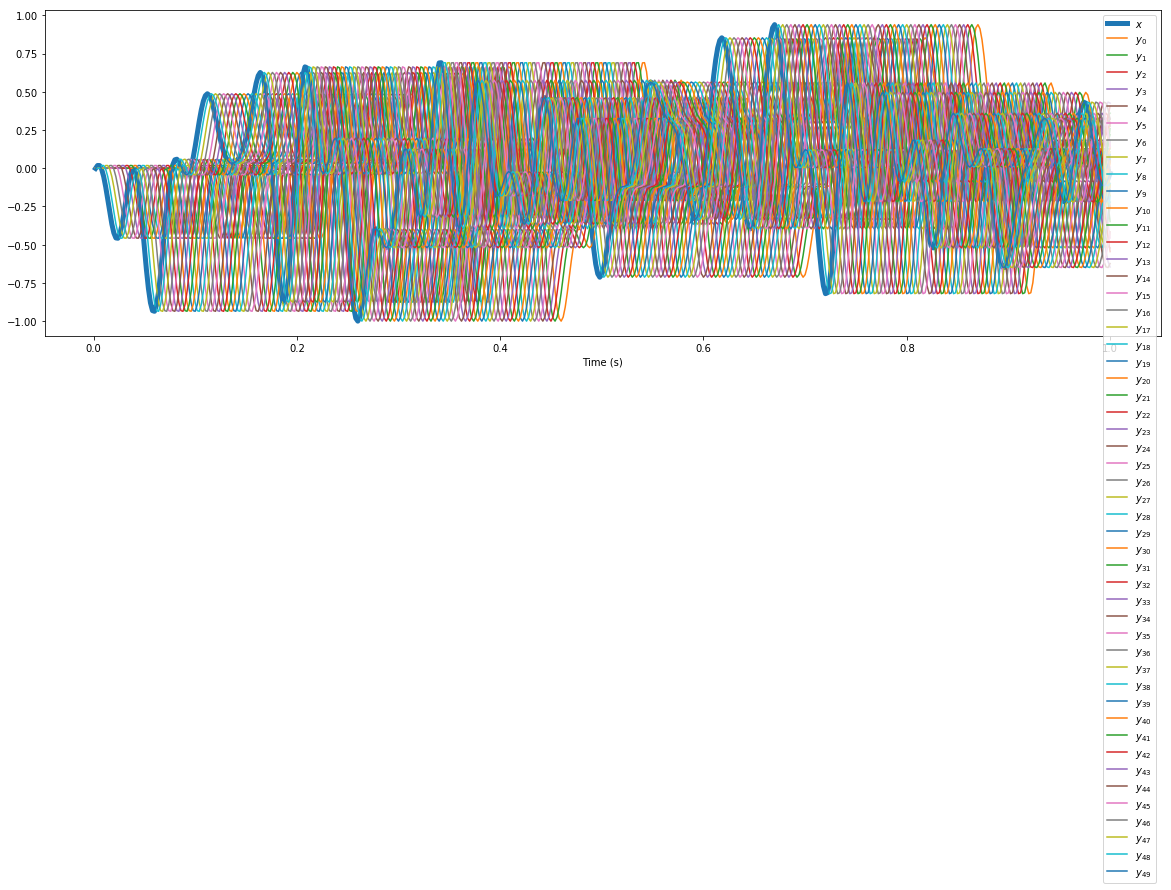

In [5]:
plt.figure(figsize=(20, 6))
plt.plot(t, X[0], label="$x$", lw=5)
for i in range(Y.shape[-1]):
    plt.plot(t, Y[0, :, i], label="$y_{%d}$" % i)
plt.legend()
plt.xlabel("Time (s)")
plt.show()

In [6]:
n_gpus = 4

def make_lstm(num_units, num_layers):
    model = Sequential()
    model.add(LSTM(num_units,
                   input_shape=(X.shape[1], 1),  # (timesteps, input_dims)
                   return_sequences=True))  # continuously outputs per timestep
    for _ in range(num_layers-1):
        model.add(LSTM(num_units, return_sequences=True))
    model.add(Dense(Y.shape[-1], activation='tanh'))

    model = multi_gpu_model(model, gpus=n_gpus)
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

def delay_layer(num_units, **kwargs):
    return RNN(DelayCell(num_units,
                         order=9,
                         #theta_initializer=RandomUniform(25, 50),
                         #encoder_initializer='lecun_uniform',
                         #decoder_initializer='lecun_normal',
                         #trainable_A=True,
                         #trainable_B=True,
                        ),
               return_sequences=True,
               **kwargs)

def make_dn(num_units, num_layers):
    model = Sequential()
    model.add(delay_layer(num_units,
                          input_shape=(X.shape[1], 1)))  # (timesteps, input_dims)
    for _ in range(num_layers-1):
        model.add(delay_layer(num_units))
    model.add(Dense(Y.shape[-1], activation='linear'))
    
    model = multi_gpu_model(model, gpus=n_gpus)
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

num_units = 50
num_layers = 3
lstm_model = make_lstm(num_units, num_layers) 
dn_model = make_dn(num_units, num_layers) 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_1_input (InputLayer)       (None, 500, 1)       0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 500, 1)       0           lstm_1_input[0][0]               
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 500, 1)       0           lstm_1_input[0][0]               
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 500, 1)       0           lstm_1_input[0][0]               
__________________________________________________________________________________________________
lambda_4 (

In [7]:
from keras.callbacks import EarlyStopping
import time

callbacks = []#EarlyStopping(monitor='val_loss', patience=5)]
             #DisplayThetas()]

def fit(model):
    start = time.time()
    epochs = 500
    result = model.fit(
        train_X, train_Y, batch_size=32,
        epochs=epochs, callbacks=callbacks, validation_split=0.25)
    return result, (time.time() - start) / epochs

In [8]:
lstm_history, lstm_time = fit(lstm_model)

Train on 96 samples, validate on 32 samples
Epoch 1/500
96/96 [==============================] - 20s 204ms/step - loss: 0.1141 - val_loss: 0.1145
Epoch 2/500
96/96 [==============================] - 11s 109ms/step - loss: 0.1134 - val_loss: 0.1137
Epoch 3/500
96/96 [==============================] - 11s 111ms/step - loss: 0.1124 - val_loss: 0.1125
Epoch 4/500
96/96 [==============================] - 11s 110ms/step - loss: 0.1111 - val_loss: 0.1107
Epoch 5/500
96/96 [==============================] - 10s 108ms/step - loss: 0.1090 - val_loss: 0.1082
Epoch 6/500
96/96 [==============================] - 11s 110ms/step - loss: 0.1064 - val_loss: 0.1056
Epoch 7/500
96/96 [==============================] - 10s 107ms/step - loss: 0.1036 - val_loss: 0.1028
Epoch 8/500
96/96 [==============================] - 10s 108ms/step - loss: 0.1009 - val_loss: 0.1002
Epoch 9/500
96/96 [==============================] - 11s 113ms/step - loss: 0.0983 - val_loss: 0.0978
Epoch 10/500
96/96 [==================

96/96 [==============================] - 11s 111ms/step - loss: 0.0199 - val_loss: 0.0218
Epoch 81/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0194 - val_loss: 0.0215
Epoch 82/500
96/96 [==============================] - 11s 110ms/step - loss: 0.0192 - val_loss: 0.0215
Epoch 83/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0192 - val_loss: 0.0211
Epoch 84/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0185 - val_loss: 0.0205
Epoch 85/500
96/96 [==============================] - 10s 108ms/step - loss: 0.0181 - val_loss: 0.0201
Epoch 86/500
96/96 [==============================] - 11s 113ms/step - loss: 0.0177 - val_loss: 0.0195
Epoch 87/500
96/96 [==============================] - 10s 108ms/step - loss: 0.0172 - val_loss: 0.0191
Epoch 88/500
96/96 [==============================] - 10s 107ms/step - loss: 0.0168 - val_loss: 0.0189
Epoch 89/500
96/96 [==============================] - 10s 108ms/step - loss: 0.0164 - 

96/96 [==============================] - 11s 112ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 160/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 161/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 162/500
96/96 [==============================] - 11s 110ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 163/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 164/500
96/96 [==============================] - 10s 108ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 165/500
96/96 [==============================] - 10s 108ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 166/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 167/500
96/96 [==============================] - 11s 110ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 168/500
96/96 [==============================] - 10s 109ms/step - loss: 

Epoch 238/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 239/500
96/96 [==============================] - 10s 108ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 240/500
96/96 [==============================] - 11s 111ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 241/500
96/96 [==============================] - 11s 111ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 242/500
96/96 [==============================] - 11s 110ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 243/500
96/96 [==============================] - 11s 111ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 244/500
96/96 [==============================] - 11s 111ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 245/500
96/96 [==============================] - 11s 110ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 246/500
96/96 [==============================] - 10s 108ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 247/500
96/96 [==============================] - 10s 108ms

Epoch 317/500
96/96 [==============================] - 10s 108ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 318/500
96/96 [==============================] - 11s 111ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 319/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 320/500
96/96 [==============================] - 11s 111ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 321/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 322/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 323/500
96/96 [==============================] - 11s 110ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 324/500
96/96 [==============================] - 10s 108ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 325/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 326/500
96/96 [==============================] - 10s 109ms

Epoch 396/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 397/500
96/96 [==============================] - 10s 108ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 398/500
96/96 [==============================] - 11s 112ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 399/500
96/96 [==============================] - 11s 110ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 400/500
96/96 [==============================] - 10s 108ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 401/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 402/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 403/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 404/500
96/96 [==============================] - 10s 108ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 405/500
96/96 [==============================] - 10s 109ms

Epoch 475/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 476/500
96/96 [==============================] - 11s 112ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 477/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 478/500
96/96 [==============================] - 10s 108ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 479/500
96/96 [==============================] - 10s 109ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 480/500
96/96 [==============================] - 10s 108ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 481/500
96/96 [==============================] - 10s 108ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 482/500
96/96 [==============================] - 10s 108ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 483/500
96/96 [==============================] - 11s 110ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 484/500
96/96 [==============================] - 10s 108ms

In [9]:
dn_history, dn_time = fit(dn_model)

Train on 96 samples, validate on 32 samples
Epoch 1/500
96/96 [==============================] - 10s 106ms/step - loss: 0.1141 - val_loss: 0.1150
Epoch 2/500
96/96 [==============================] - 5s 56ms/step - loss: 0.1141 - val_loss: 0.1150
Epoch 3/500
96/96 [==============================] - 5s 55ms/step - loss: 0.1141 - val_loss: 0.1150
Epoch 4/500
96/96 [==============================] - 5s 56ms/step - loss: 0.1141 - val_loss: 0.1149
Epoch 5/500
96/96 [==============================] - 5s 56ms/step - loss: 0.1141 - val_loss: 0.1149
Epoch 6/500
96/96 [==============================] - 5s 55ms/step - loss: 0.1141 - val_loss: 0.1149
Epoch 7/500
96/96 [==============================] - 5s 55ms/step - loss: 0.1140 - val_loss: 0.1148
Epoch 8/500
96/96 [==============================] - 5s 56ms/step - loss: 0.1139 - val_loss: 0.1147
Epoch 9/500
96/96 [==============================] - 5s 56ms/step - loss: 0.1137 - val_loss: 0.1144
Epoch 10/500
96/96 [==============================] - 

96/96 [==============================] - 5s 55ms/step - loss: 0.0289 - val_loss: 0.0310
Epoch 82/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0284 - val_loss: 0.0305
Epoch 83/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0280 - val_loss: 0.0302
Epoch 84/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0277 - val_loss: 0.0298
Epoch 85/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0273 - val_loss: 0.0296
Epoch 86/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0271 - val_loss: 0.0293
Epoch 87/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0268 - val_loss: 0.0290
Epoch 88/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0265 - val_loss: 0.0287
Epoch 89/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0263 - val_loss: 0.0285
Epoch 90/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0261 - val_loss: 0.0282
Epo

96/96 [==============================] - 5s 55ms/step - loss: 0.0187 - val_loss: 0.0204
Epoch 162/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0187 - val_loss: 0.0203
Epoch 163/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0186 - val_loss: 0.0203
Epoch 164/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0186 - val_loss: 0.0202
Epoch 165/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0185 - val_loss: 0.0202
Epoch 166/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0185 - val_loss: 0.0202
Epoch 167/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0184 - val_loss: 0.0201
Epoch 168/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0184 - val_loss: 0.0200
Epoch 169/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0183 - val_loss: 0.0200
Epoch 170/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0183 - val_loss: 0

96/96 [==============================] - 5s 55ms/step - loss: 0.0160 - val_loss: 0.0176
Epoch 242/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0160 - val_loss: 0.0176
Epoch 243/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0160 - val_loss: 0.0176
Epoch 244/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0160 - val_loss: 0.0176
Epoch 245/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0160 - val_loss: 0.0175
Epoch 246/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0160 - val_loss: 0.0175
Epoch 247/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0159 - val_loss: 0.0176
Epoch 248/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0159 - val_loss: 0.0176
Epoch 249/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0159 - val_loss: 0.0175
Epoch 250/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0159 - val_loss: 0

96/96 [==============================] - 5s 56ms/step - loss: 0.0148 - val_loss: 0.0164
Epoch 322/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0148 - val_loss: 0.0164
Epoch 323/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0148 - val_loss: 0.0164
Epoch 324/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0148 - val_loss: 0.0164
Epoch 325/500
96/96 [==============================] - 5s 54ms/step - loss: 0.0148 - val_loss: 0.0163
Epoch 326/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0148 - val_loss: 0.0163
Epoch 327/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0148 - val_loss: 0.0164
Epoch 328/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0148 - val_loss: 0.0163
Epoch 329/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0148 - val_loss: 0.0163
Epoch 330/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0148 - val_loss: 0

96/96 [==============================] - 5s 55ms/step - loss: 0.0140 - val_loss: 0.0155
Epoch 402/500
96/96 [==============================] - 5s 57ms/step - loss: 0.0140 - val_loss: 0.0155
Epoch 403/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0140 - val_loss: 0.0155
Epoch 404/500
96/96 [==============================] - 5s 57ms/step - loss: 0.0140 - val_loss: 0.0155
Epoch 405/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0140 - val_loss: 0.0155
Epoch 406/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0140 - val_loss: 0.0154
Epoch 407/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0139 - val_loss: 0.0155
Epoch 408/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0139 - val_loss: 0.0154
Epoch 409/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0139 - val_loss: 0.0154
Epoch 410/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0139 - val_loss: 0

96/96 [==============================] - 5s 56ms/step - loss: 0.0124 - val_loss: 0.0138
Epoch 482/500
96/96 [==============================] - 5s 57ms/step - loss: 0.0124 - val_loss: 0.0137
Epoch 483/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0124 - val_loss: 0.0137
Epoch 484/500
96/96 [==============================] - 5s 56ms/step - loss: 0.0123 - val_loss: 0.0137
Epoch 485/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0123 - val_loss: 0.0136
Epoch 486/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0123 - val_loss: 0.0136
Epoch 487/500
96/96 [==============================] - 5s 57ms/step - loss: 0.0123 - val_loss: 0.0136
Epoch 488/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0122 - val_loss: 0.0135
Epoch 489/500
96/96 [==============================] - 5s 55ms/step - loss: 0.0122 - val_loss: 0.0135
Epoch 490/500
96/96 [==============================] - 5s 57ms/step - loss: 0.0122 - val_loss: 0

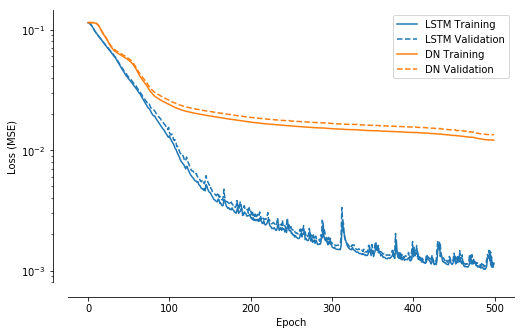

In [10]:
from phd import savefig

colors = sns.color_palette(None, 2)

plt.figure(figsize=(8, 5))
plt.plot(lstm_history.history['loss'], c=colors[0], label="LSTM Training")
plt.plot(lstm_history.history['val_loss'], c=colors[0], label="LSTM Validation", linestyle='--')

plt.plot(dn_history.history['loss'], c=colors[1], label="DN Training")
plt.plot(dn_history.history['val_loss'], c=colors[1], label="DN Validation", linestyle='--')

plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.yscale('log')
plt.legend()

sns.despine(offset=15)

savefig('lstm-capacity-training-easier.pdf')

plt.show()

In [11]:
lstm_Y = lstm_model.predict(test_X)
dn_Y = dn_model.predict(test_X)

In [12]:
from pandas import DataFrame
from collections import defaultdict
from nengolib.signal import nrmse

theta_label = r'Delay Length (# Steps)'

errors = defaultdict(list)
for name, pred_Y in (("LSTM", lstm_Y), ("DN", dn_Y)):
    for i in range(Y.shape[-1]):
        for j, case in enumerate(nrmse(pred_Y[:, :, i], target=test_Y[:, :, i], axis=1)):
            errors[theta_label].append(thetas[i] / dt)
            errors['NRMSE'].append(case)
            errors['Test'].append(j)
            errors['Method'].append(name)

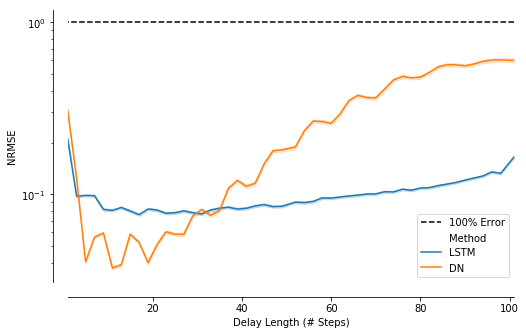

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(thetas / dt, np.ones_like(thetas), linestyle='--', c='black', label="100% Error")
sns.lineplot(data=DataFrame(errors), x=theta_label, y="NRMSE", hue="Method")
#plt.xscale('log')
plt.yscale('log')
plt.xlim(np.min(errors[theta_label]), np.max(errors[theta_label]))
sns.despine(offset=15)

savefig('lstm-capacity-testing-easier.pdf')

plt.show()

In [14]:
print(lstm_time, dn_time)

10.524228610515594 5.3427026381492615


In [15]:
from phd import datapath

lstm_model.save(datapath("keras-lstm-capacity-easier.hdf5"))
dn_model.save(datapath("keras-dn-capacity-easier.hdf5"))